# Using a New Machine Learning Classifier for Algorithmic Trading

## Background

Choosing a machine learning model to use in a trading strategy is a matter of trial and error. In this way, you find a model that produces the desired outcomes with an acceptable level of performance.

In the machine learning section of the boot camp, you learned about some classification models, such as logistic regression, support vector machines (SVM), and neural networks. In this activity, you'll train a logistic regression model to make trading predictions, backtest the results, and then evaluate its performance compared to that of a SVM model.

## Instructions:

1. Open the provided starter code. Inspect and run all the cells up to the “Add a New Machine Learning Model” section to review the data loading and preparation process, as well as the inclusion of a SVM model in a trading algorithm.

2. Import the `LogisticRegression` model from scikit-learn.

    > **Rewind** Recall that `LogisticRegression` models are used for binary classification problems.

3. Using the same training data that the SVM model used (`X_train_scaled` and `y_train`), fit the `LogisticRegression` model.

4. Use the trained model to predict the trading signals for the training data. Use the `classification_report` module to evaluate the model.

5. Backtest the `LogisticRegression` model to evaluate its performance.

6. Compare the performance of the logistic regression and SVM models using the classification reports generated with the testing data.  Did the logistic regression model perform better than SVM? Write down your conclusions to share with the class.


## References

* [SKLearn SVM - SVC Classifier](https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html)

* [SKLearn LogisticRegression](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html)

---

In [1]:
# Imports
import pandas as pd
from pathlib import Path

### Read the CSV file into Pandas DataFrame

In [2]:
# Import the OHLCV dataset into a Pandas Dataframe
trading_df = pd.read_csv(
    Path("stock_data.csv"), 
    index_col="Date", 
    infer_datetime_format=True, 
    parse_dates=True
)

# Review the DataFrame
trading_df.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2018-12-31,39.632500,39.840000,39.119999,39.435001,38.233902,140014000
2019-01-02,38.722500,39.712502,38.557499,39.480000,38.277519,148158800
2019-01-03,35.994999,36.430000,35.500000,35.547501,34.464806,365248800
2019-01-04,36.132500,37.137501,35.950001,37.064999,35.936073,234428400
2019-01-07,37.174999,37.207500,36.474998,36.982498,35.856091,219111200


### Add a daily return values column to the DataFrame

In [3]:
# Calculate the daily returns using the closing prices and the pct_change function
trading_df["actual_returns"] = trading_df["Close"].pct_change()

# Drop all NaN values from the DataFrame
trading_df = trading_df.dropna()

# Review the DataFrame
display(trading_df.head())
display(trading_df.tail())

,Open,High,Low,Close,Adj Close,Volume,actual_returns
Date,,,,,,,
2019-01-02,38.722500,39.712502,38.557499,39.480000,38.277519,148158800,0.001141
2019-01-03,35.994999,36.430000,35.500000,35.547501,34.464806,365248800,-0.099607
2019-01-04,36.132500,37.137501,35.950001,37.064999,35.936073,234428400,0.042689
2019-01-07,37.174999,37.207500,36.474998,36.982498,35.856091,219111200,-0.002226
2019-01-08,37.389999,37.955002,37.130001,37.687500,36.539616,164101200,0.019063


,Open,High,Low,Close,Adj Close,Volume,actual_returns
Date,,,,,,,
2022-03-31,177.839996,178.029999,174.399994,174.610001,174.610001,103049300,-0.017776
2022-04-01,174.029999,174.880005,171.940002,174.309998,174.309998,78699800,-0.001718
2022-04-04,174.570007,178.490005,174.440002,178.440002,178.440002,76468400,0.023693
2022-04-05,177.500000,178.300003,174.419998,175.059998,175.059998,73401800,-0.018942
2022-04-06,172.360001,173.630005,170.130005,171.830002,171.830002,88950300,-0.018451


---

### Generating the Features and Target Sets

In [4]:
# Define a window size of 4
short_window = 4

# Create a simple moving average (SMA) using the short_window and assign this to a new columns called sma_fast
trading_df["sma_fast"] = trading_df["Close"].rolling(window=short_window).mean()

In [5]:
# Define a window size of 100
long_window = 100

# Create a simple moving average (SMA) using the long_window and assign this to a new columns called sma_slow
trading_df["sma_slow"] = trading_df["Close"].rolling(window=long_window).mean()

In [6]:
# Drop the NaNs using dropna()
trading_df = trading_df.dropna()

#### Create the features set

In [7]:
# Assign a copy of the sma_fast and sma_slow columns to a new DataFrame called X
X = trading_df[["sma_fast", "sma_slow"]].copy()

# Display sample data
display(X.head())
display(X.tail())

,sma_fast,sma_slow
Date,,
2019-05-24,45.500626,45.148425
2019-05-28,44.977500,45.199200
2019-05-29,44.640000,45.287175
2019-05-30,44.555000,45.362275
2019-05-31,44.311251,45.430125


,sma_fast,sma_slow
Date,,
2022-03-31,176.735004,167.309601
2022-04-01,176.412502,167.548300
2022-04-04,176.282501,167.824601
2022-04-05,175.605000,168.096001
2022-04-06,174.910000,168.335601


#### Create the target set

In [8]:
# Create a new column in the trading_df called signal setting its value to zero.
trading_df["signal"] = 0.0

In [9]:
# Create the signal to buy
trading_df.loc[(trading_df["actual_returns"] >= 0), "signal"] = 1

In [10]:
# Create the signal to sell
trading_df.loc[(trading_df["actual_returns"] < 0), "signal"] = -1

In [11]:
# Copy the new signal column to a new Series called y.
y = trading_df["signal"].copy()

---

### Split the Data Into Training and Testing Datasets

#### Creating the Training Datasets

In [12]:
# Imports 
from pandas.tseries.offsets import DateOffset

In [13]:
# Select the start of the training period
training_begin = X.index.min()

# Display the training begin date
print(training_begin)

2019-05-24 00:00:00


In [14]:
# Select the ending period for the training data with an offset of 3 months
training_end = X.index.min() + DateOffset(months=3)

# Display the training end date
print(training_end)

2019-08-24 00:00:00


In [15]:
# Generate the X_train and y_train DataFrames
X_train = X.loc[training_begin:training_end]
y_train = y.loc[training_begin:training_end]

# Display sample data
X_train.head()

,sma_fast,sma_slow
Date,,
2019-05-24,45.500626,45.148425
2019-05-28,44.977500,45.199200
2019-05-29,44.640000,45.287175
2019-05-30,44.555000,45.362275
2019-05-31,44.311251,45.430125


#### Creating the Testing Datasets

In [16]:
# Generate the X_test and y_test DataFrames
X_test = X.loc[training_end:]
y_test = y.loc[training_end:]

# Display sample data
X_test.head()

,sma_fast,sma_slow
Date,,
2019-08-26,52.139376,49.735050
2019-08-27,51.609376,49.756225
2019-08-28,51.176250,49.777550
2019-08-29,51.574375,49.799825
2019-08-30,51.715000,49.822925


#### Standardizing the Data

In [17]:
# Imports
from sklearn.preprocessing import StandardScaler

In [18]:
# Create a StandardScaler instance
scaler = StandardScaler()
 
# Apply the scaler model to fit the X-train data
X_scaler = scaler.fit(X_train)
 
# Transform the X_train and X_test DataFrames using the X_scaler
X_train_scaled = X_scaler.transform(X_train)
X_test_scaled = X_scaler.transform(X_test)

---

### Incorporate the SVM Machine Learning Into the Trading Strategy

In [19]:
# Imports
from sklearn import svm
from sklearn.metrics import classification_report

In [20]:
# Create the classifier model
svm_model = svm.SVC()
 
# Fit the model to the data using X_train_scaled and y_train
svm_model = svm_model.fit(X_train_scaled, y_train)

# Use the trained model to predict the trading signals for the training data
training_signal_predictions = svm_model.predict(X_train_scaled)

# Display the sample predictions
training_signal_predictions[:10]

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])

In [21]:
# Evaluate the model using a classification report
training_report = classification_report(y_train, training_signal_predictions)
print(training_report)

              precision    recall  f1-score   support

        -1.0       0.55      0.56      0.55        32
         1.0       0.55      0.53      0.54        32

    accuracy                           0.55        64
   macro avg       0.55      0.55      0.55        64
weighted avg       0.55      0.55      0.55        64



---

### Backtesting a Machine Learning Trading Algorithm

In [22]:
# Use the trained model to predict the trading signals for the testing data.
testing_signal_predictions = svm_model.predict(X_test_scaled)

In [23]:
# Evaluate the model's ability to predict the trading signal for the testing data
svm_testing_report = classification_report(y_test, testing_signal_predictions)
print(svm_testing_report)

              precision    recall  f1-score   support

        -1.0       0.46      1.00      0.63       303
         1.0       1.00      0.00      0.01       357

    accuracy                           0.46       660
   macro avg       0.73      0.50      0.32       660
weighted avg       0.75      0.46      0.29       660



In [24]:
# Create a new empty predictions DataFrame using code provided below.
predictions_df = pd.DataFrame(index=X_test.index)
predictions_df["predicted_signal"] = testing_signal_predictions
predictions_df["actual_returns"] = trading_df["actual_returns"]
predictions_df["trading_algorithm_returns"] = predictions_df["actual_returns"] * predictions_df["predicted_signal"]
predictions_df.head()

,predicted_signal,actual_returns,trading_algorithm_returns
Date,,,
2019-08-26,-1.0,0.018999,-0.018999
2019-08-27,-1.0,-0.011284,0.011284
2019-08-28,1.0,0.006710,0.006710
2019-08-29,-1.0,0.016932,-0.016932
2019-08-30,-1.0,-0.001292,0.001292


<AxesSubplot:xlabel='Date'>

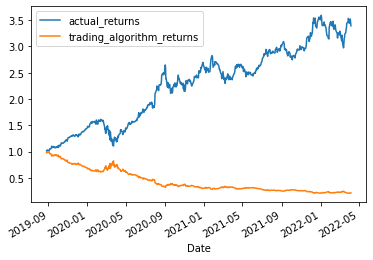

In [25]:
# Calculate and plot the cumulative returns for the `actual_returns` and the `trading_algorithm_returns`
(1 + predictions_df[["actual_returns", "trading_algorithm_returns"]]).cumprod().plot()

---

# Add a New Machine Learning Model

## Import the `LogisticRegression` model from scikit-learn.


In [26]:
# Import LogisticRegression from sklearn
from sklearn.linear_model import LogisticRegression

In [27]:
# Create an instance of the LogisticRegression model
logistic_regression_model = LogisticRegression()


## Using the same training data that the SVM model used (`X_train_scaled` and `y_train`), fit the `LogisticRegression` model.

In [28]:
# Fit the LogisticRegression model
logistic_regression_model = logistic_regression_model.fit(X_train_scaled, y_train)


## Use the trained model to predict the trading signals for the training data. Use the `classification_report` module to evaluate the model.

In [29]:
# Use the trained LogisticRegression model to predict the trading signals for the training data
lr_training_signal_predictions = logistic_regression_model.predict(X_train_scaled)

# Display the predictions
lr_training_signal_predictions[:10]


array([-1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.])

In [30]:
# Generate a classification report using the training data and the logistic regression model's predications
lr_training_report = classification_report(y_train, lr_training_signal_predictions)

# Review the classification report
print(lr_training_report)


              precision    recall  f1-score   support

        -1.0       0.53      0.66      0.58        32
         1.0       0.54      0.41      0.46        32

    accuracy                           0.53        64
   macro avg       0.53      0.53      0.52        64
weighted avg       0.53      0.53      0.52        64



## Backtest the `LogisticRegression` model using the testing data to evaluate its performance.

In [31]:
# Use the trained model to predict the trading signals for the testing data.
lr_testing_signal_predictions = logistic_regression_model.predict(X_test_scaled)

In [32]:
# Generate a classification report using the testing data and the logistic regression model's predications
lr_testing_report = classification_report(y_test, lr_testing_signal_predictions)

# Review the classification report
print(lr_testing_report)


              precision    recall  f1-score   support

        -1.0       0.39      0.15      0.22       303
         1.0       0.53      0.80      0.63       357

    accuracy                           0.50       660
   macro avg       0.46      0.48      0.43       660
weighted avg       0.46      0.50      0.44       660



## Compare the performance of the logistic regression and SVM models using the classification reports generated with the testing data. 

In [33]:
# Print the classification report for the SVM model using the test data
print("Logistic Regression Classification Report")
print(lr_testing_report)


Logistic Regression Classification Report
              precision    recall  f1-score   support

        -1.0       0.39      0.15      0.22       303
         1.0       0.53      0.80      0.63       357

    accuracy                           0.50       660
   macro avg       0.46      0.48      0.43       660
weighted avg       0.46      0.50      0.44       660



In [34]:
# Print the classification report for the SVM model using the test data
print("SVM Classification Report")
print(svm_testing_report)


SVM Classification Report
              precision    recall  f1-score   support

        -1.0       0.46      1.00      0.63       303
         1.0       1.00      0.00      0.01       357

    accuracy                           0.46       660
   macro avg       0.73      0.50      0.32       660
weighted avg       0.75      0.46      0.29       660



### Answer the following question:

**Question:** Did the `LogisticRegression` perform better than the `SVM`?

**Answer:** Yes